In [1]:
import numpy as np
import scipy
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import re
import os
from tqdm import tqdm
import math
import nltk
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from bs4 import BeautifulSoup
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
import xml.etree.ElementTree as etree
import time
import spacy
from spacy import displacy
from wordcloud import WordCloud

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [3]:
def post_to_words( post_text, stopwords_lem=True):
    # 2. Remove non-letters
    post_text = re.sub(r"(\\n)|(\.\\n)|(\'\w+)|(http*\S+)|[^\w\s\.,#+-]", " ", post_text)
    post_text = re.sub(r"(\.\s)|(\.$)|(,\s)|(\s#\s)|(\'\w+)|(\s\-\s)", " ", post_text)
    post_text = re.sub(r"(\s-?\+?\d{0,4}\s)", " ", post_text)
    post_text = re.sub(r"\s+", " ", post_text)
    #
    # 3. Convert to lower case, split into individual words
    words = post_text.lower().split()
    #
    if stopwords_lem :
        # 4. In Python, searching a set is much faster than searching
        # a list, so convert the stop words to a set
        # 5. Remove stop words
        words = [w for w in words if not w in stops]
        # 6. Join the words back into one string separated by space,
        # and return the result.
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join( words )

In [4]:
def clean_html_body(x):
    soup = BeautifulSoup(x)
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return soup.get_text()

In [5]:
def clean_tags(x):
    tag_iter = []
    for tag in x:
        if tag in Tags_name_list:
            tag_iter.append(tag)
    return tag_iter

In [6]:
def split_tags(x):
    return re.sub(r"><", " ", re.sub(r"^<|>$", "", x)).split()

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

## Préparation des données

### de l'XML au CSV

In [129]:
outro = "</posts>"
it = 0
valid = 0
count = 1
start_time = time.time()
with open('Data/Posts.xml', 'r', encoding='utf8') as inputFile :
    outputLine = []
    intro = []
    intro.append(inputFile.readline())
    intro.append(inputFile.readline())
    outputLine.extend(intro)
    for inputLine in inputFile :
        if 'PostTypeId="1"' in inputLine :
            outputLine.append(inputLine)
            valid += 1
            if valid % 100000 == 0 :
                interval = time.time() - start_time
                print("{:,} lignes de gardées sur {:,}. ça avance    ".format(valid, it) + '{h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
            if valid % 1000000 == 0 :
                outputLine.append(outro)
                interval = time.time() - start_time
                with open('Data/PostsXML_lite' + str(count) + '.xml', 'w', encoding='utf8') as outputFile :
                    outputFile.writelines(outputLine)
                print("{:,} lignes de gardées sur {:,} : les données sont conservées sur Data/PostsXML_lite".format(valid, it)+ str(count) +".xml")
                count += 1
                outputLine = []
                outputLine.extend(intro)
        it += 1
    outputLine.append(outro)
    interval = time.time() - start_time
    with open('Data/PostsXML_lite' + str(count) + '.xml', 'w', encoding='utf8') as outputFile :
        outputFile.writelines(outputLine)
    print("{:,} lignes de gardées sur {:,} : les données sont conservées sur Data/PostsXML_lite".format(valid, it)+ str(count) +".xml")

100,000 lignes de gardée sur 448,943. sa avance    0:3.339 temps passé
200,000 lignes de gardée sur 835,699. sa avance    0:6.101 temps passé
300,000 lignes de gardée sur 1,192,225. sa avance    0:9.047 temps passé
400,000 lignes de gardée sur 1,546,639. sa avance    0:11.797 temps passé
500,000 lignes de gardée sur 1,881,292. sa avance    0:15.149 temps passé
600,000 lignes de gardée sur 2,198,260. sa avance    0:19.164 temps passé
700,000 lignes de gardée sur 2,508,141. sa avance    0:23.225 temps passé
800,000 lignes de gardée sur 2,815,320. sa avance    0:26.580 temps passé
900,000 lignes de gardée sur 3,118,678. sa avance    0:29.466 temps passé
1,000,000 lignes de gardée sur 3,421,560. sa avance    0:32.265 temps passé
fichier Data/PostsXML_lite1.xml sauvegardé
1,000,000 lignes de gardée sur 3,421,560 : les données sont conservées sur Data/PostsXML_lite1.xml
1,100,000 lignes de gardée sur 3,724,175. sa avance    0:45.818 temps passé
1,200,000 lignes de gardée sur 4,024,616. sa av

In [3]:
row = 0
count = 23
start_time = time.time()
for it in range(1, count) :
    postXML = []
    for event, elem in etree.iterparse("Data/PostsXML_lite" + str(it) + ".xml"):
        if elem.tag == 'row' :
            row += 1
            postXML.append(elem.attrib)
            if row % 100000 == 0 :
                interval = time.time() - start_time
                print("{:,} lignes traitées. ça avance    ".format(row) + '{h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
    pd.DataFrame(postXML).to_csv("Data/PostsXML_"+ str(it) +".csv")
    print("{:,} lignes de traitées : les données sont conservées sur Data/PostsXML_".format(row)+ str(it) +".csv")
    os.remove("Data/PostsXML_lite" + str(it) + ".xml")

100,000 lignes traité. sa avance    0:7.415 temps passé
200,000 lignes traité. sa avance    0:15.107 temps passé
300,000 lignes traité. sa avance    0:22.724 temps passé
400,000 lignes traité. sa avance    0:29.998 temps passé
500,000 lignes traité. sa avance    0:37.547 temps passé
600,000 lignes traité. sa avance    0:44.859 temps passé
700,000 lignes traité. sa avance    0:51.406 temps passé
800,000 lignes traité. sa avance    0:58.811 temps passé
900,000 lignes traité. sa avance    1:5.539 temps passé
978,327 lignes de traité : les données sont conservées sur Data/PostsXML_22.csv


## Nouveau Nettoyage

In [8]:
postXML1 = pd.read_csv('Data/PostsXML_6.csv', index_col=0)
postXML1['Tags_list'] = postXML1['Tags'].apply(split_tags)
tags_binarizer = MultiLabelBinarizer(sparse_output=True)
Tags = tags_binarizer.fit_transform(postXML1.Tags_list)
Tags_list = pd.DataFrame(data={"Nom":tags_binarizer.classes_.tolist(), "Nombre": Tags.sum(axis=0).tolist()[0]}).sort_values(by="Nombre", ascending=False, ignore_index=True)

### Analyse exploratoire

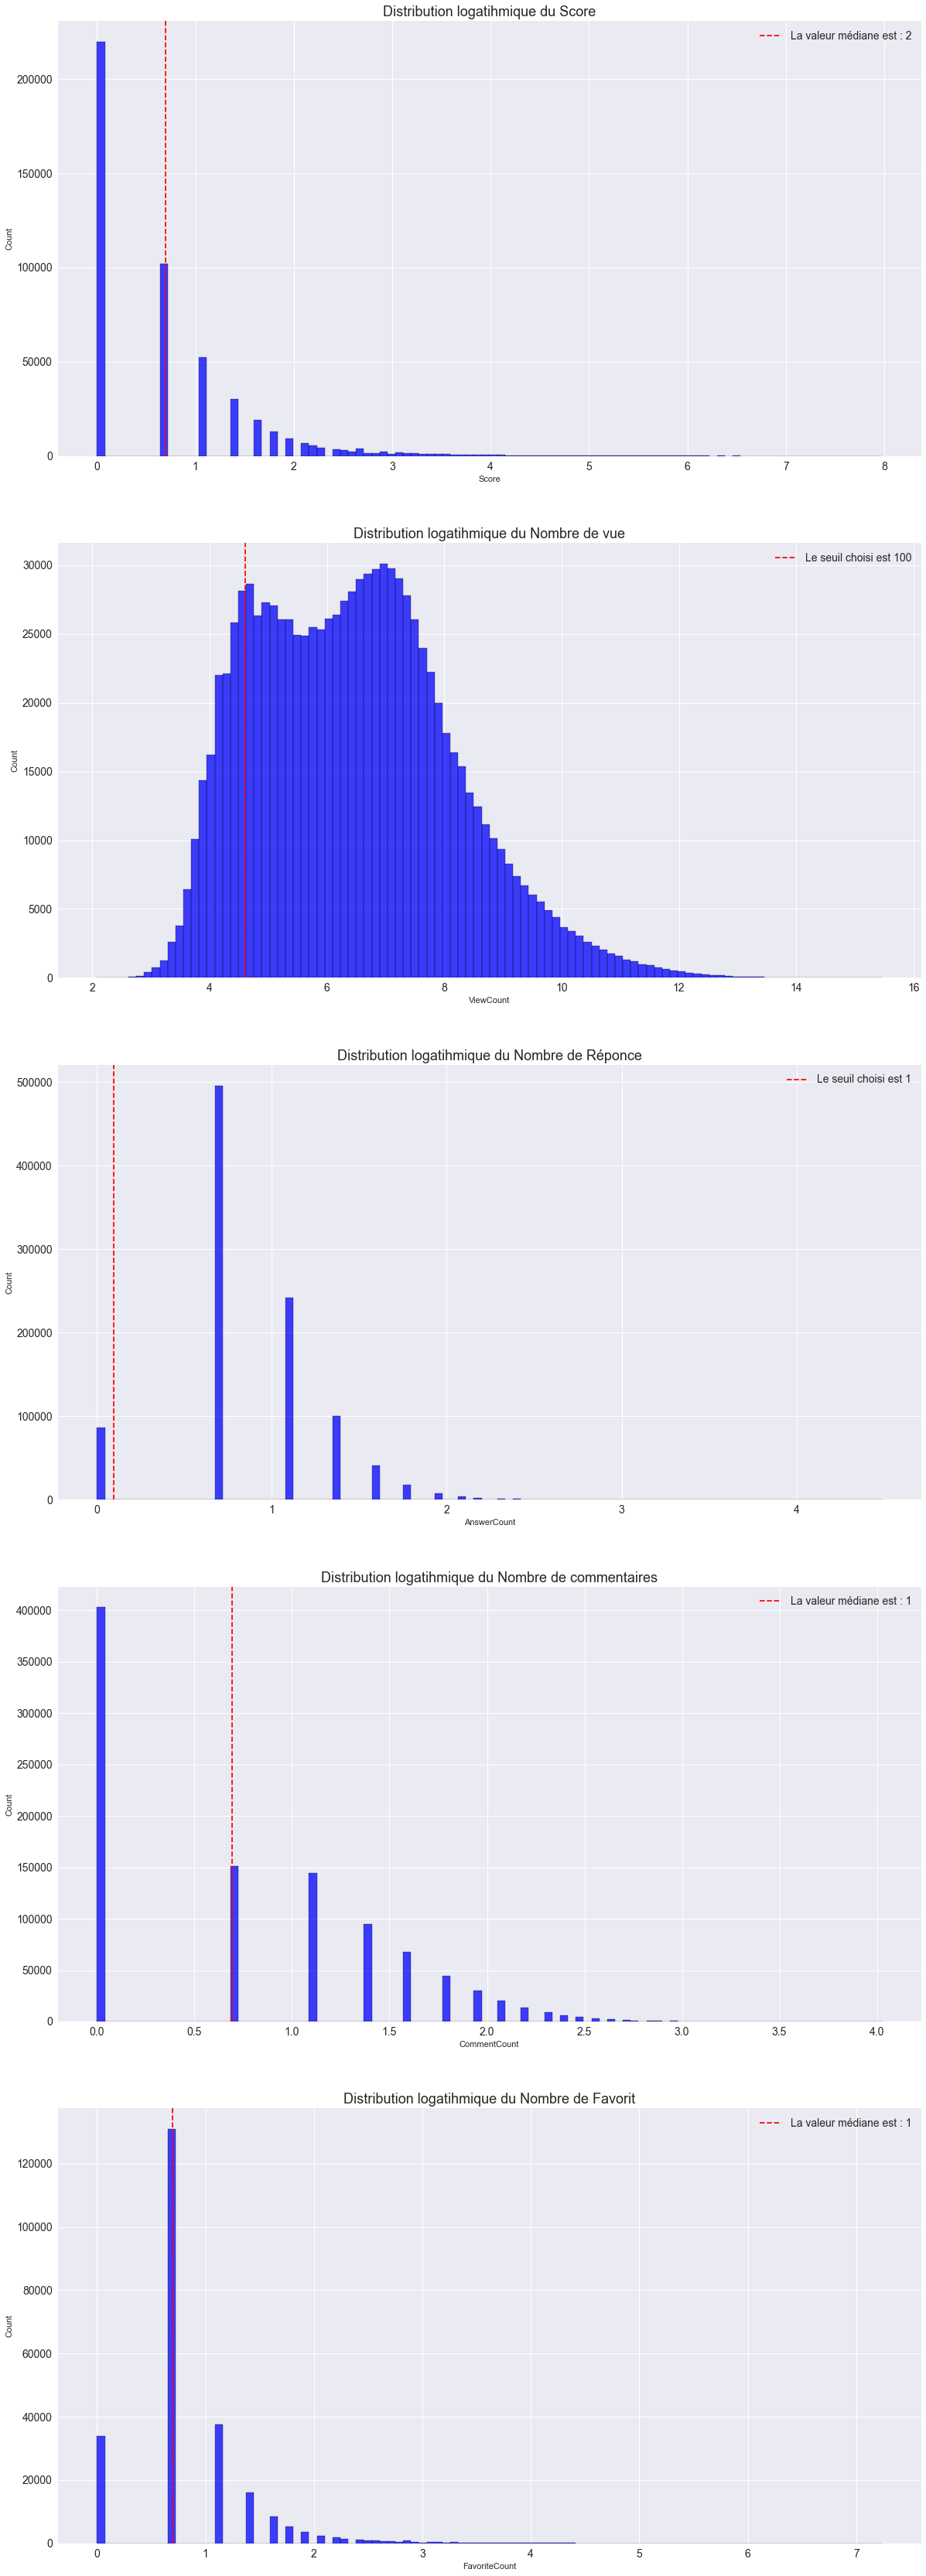

In [10]:
fig = plt.figure(figsize=(20, 12*5))

plt.subplot(511)
sns.histplot(np.log(postXML1[postXML1['Score'] > 0]['Score']), bins=100, color="blue")
plt.title("Distribution logatihmique du Score", fontsize=18)
plt.axvline(np.log(postXML1[postXML1['Score'] > 0]['Score']).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1[postXML1['Score'] > 0]['Score'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(512)
sns.histplot(np.log(postXML1['ViewCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de vue", fontsize=18)
plt.axvline(math.log(100), color="r", linestyle='--', label="Le seuil choisi est 100")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(513)
sns.histplot(np.log(postXML1['AnswerCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de Réponse", fontsize=18)
plt.axvline(math.log(1.1), color="r", linestyle='--', label="Le seuil choisi est 1")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(514)
sns.histplot(np.log(postXML1['CommentCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de commentaires", fontsize=18)
plt.axvline(np.log(postXML1['CommentCount'] + 1).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1['CommentCount'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(515)
sns.histplot(np.log(postXML1['FavoriteCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de Favorit", fontsize=18)
plt.axvline(np.log(postXML1['FavoriteCount'] + 1).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1['FavoriteCount'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


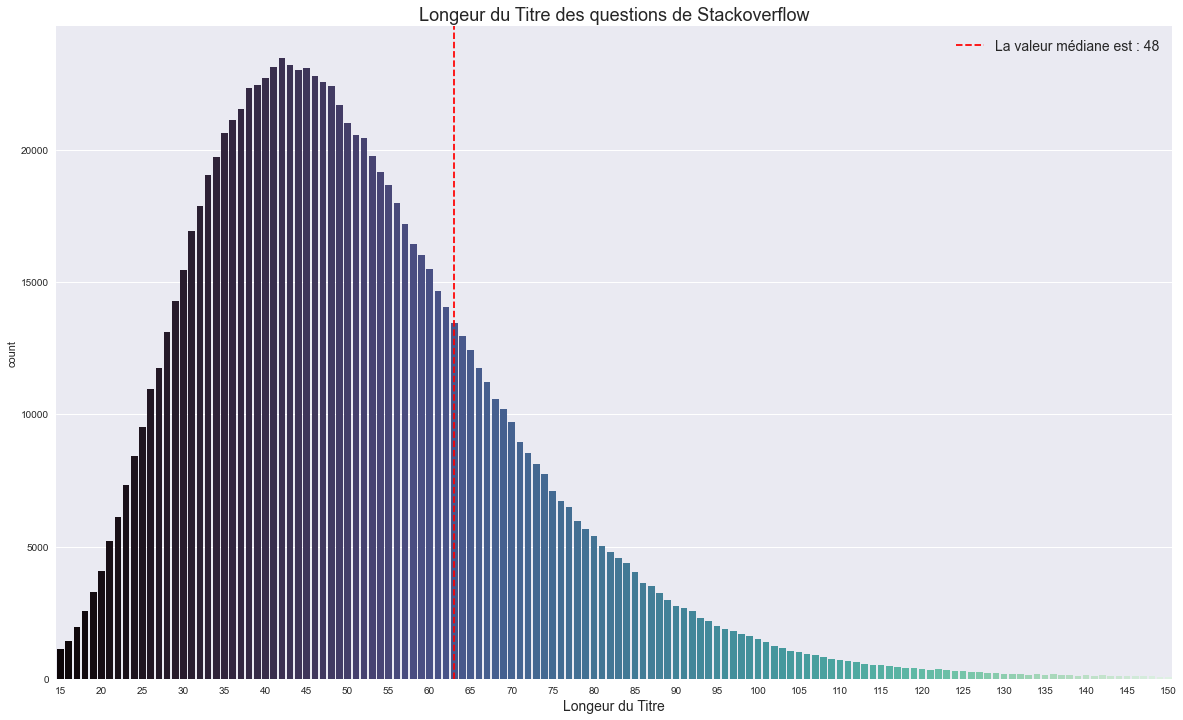

In [11]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML1.Title.str.len(), palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(postXML1.Title.str.len().median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1.Title.str.len().median()))
ax.set_xlabel("Longeur du Titre", fontsize=14)
plt.title("Longeur du Titre des questions de Stackoverflow",
          fontsize=18)
plt.legend(fontsize=14)
plt.show()


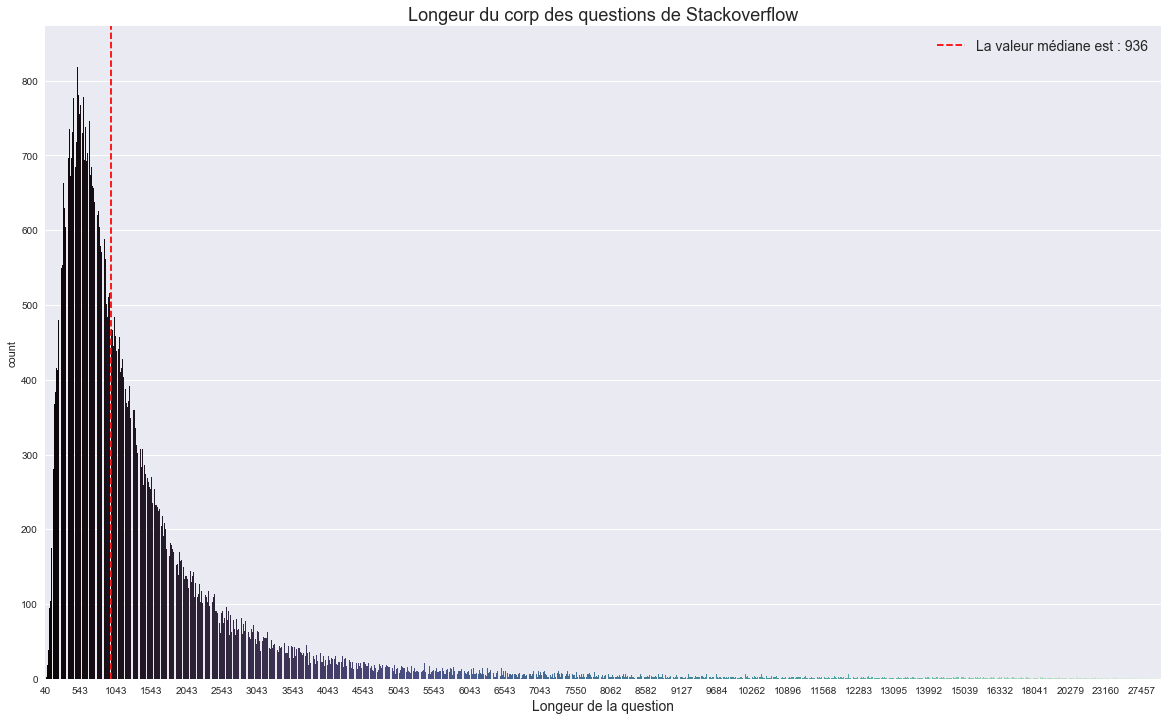

In [12]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML1.Body.str.len(), palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 500))
plt.axvline(postXML1.Body.str.len().median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1.Body.str.len().median()))
ax.set_xlabel("Longeur de la question", fontsize=14)
plt.title("Longeur du corp des questions de Stackoverflow", fontsize=18)
plt.legend(fontsize=14)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


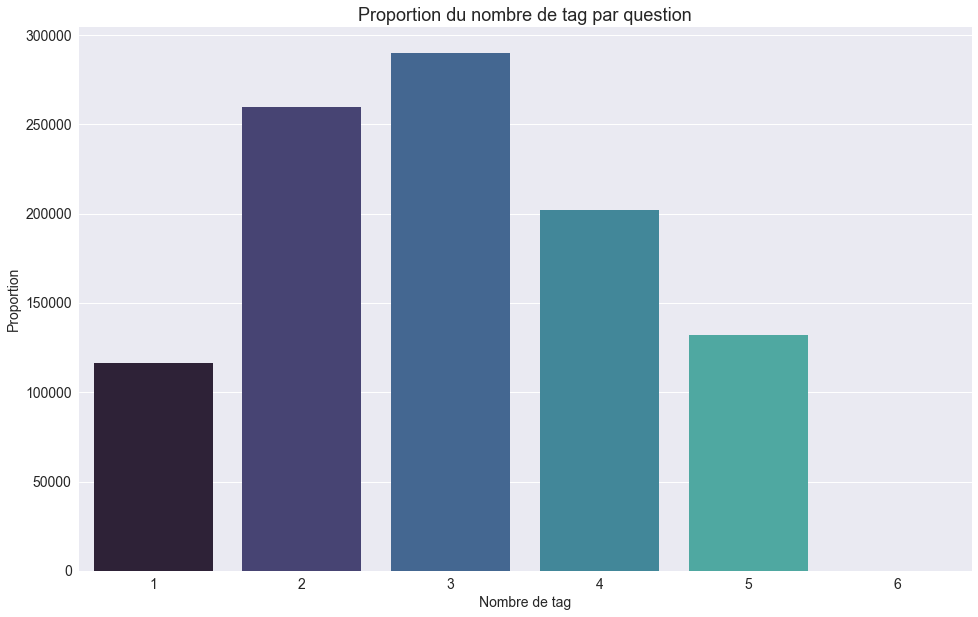

In [13]:
fig = plt.figure(figsize=(16, 10))
sns.countplot(postXML1['Tags_list'].str.len(), palette="mako")
plt.title("Proportion du nombre de tag par question", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Nombre de tag", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.show()

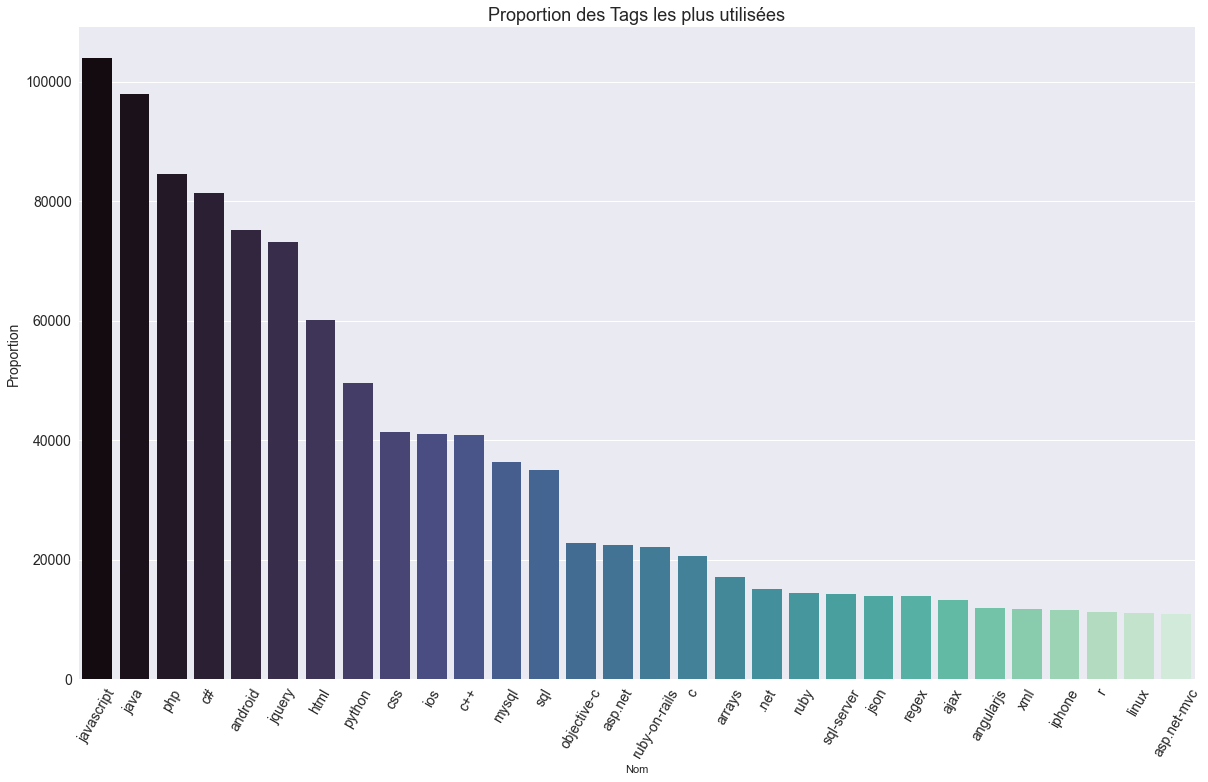

In [14]:
fig = plt.figure(figsize=(20, 12))
sns.barplot(x=Tags_list[:30]['Nom'], y=Tags_list[:30]['Nombre'], palette="mako")
plt.title("Proportion des Tags les plus utilisées", fontsize=18)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)
plt.show()


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

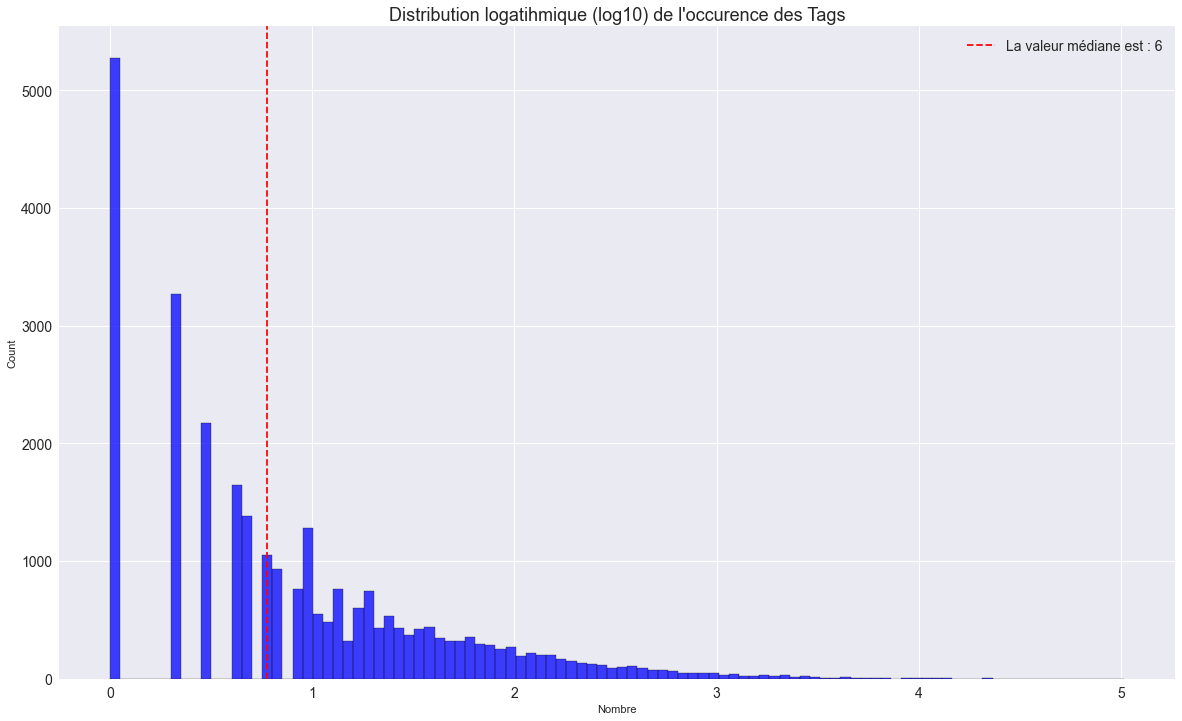

In [15]:
fig = plt.figure(figsize=(20, 12))
sns.histplot(np.log10(Tags_list['Nombre']), bins=100, color="blue")
plt.title("Distribution logatihmique (log10) de l'occurence des Tags",
          fontsize=18)
plt.axvline(np.log10(Tags_list['Nombre']).median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(Tags_list['Nombre'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

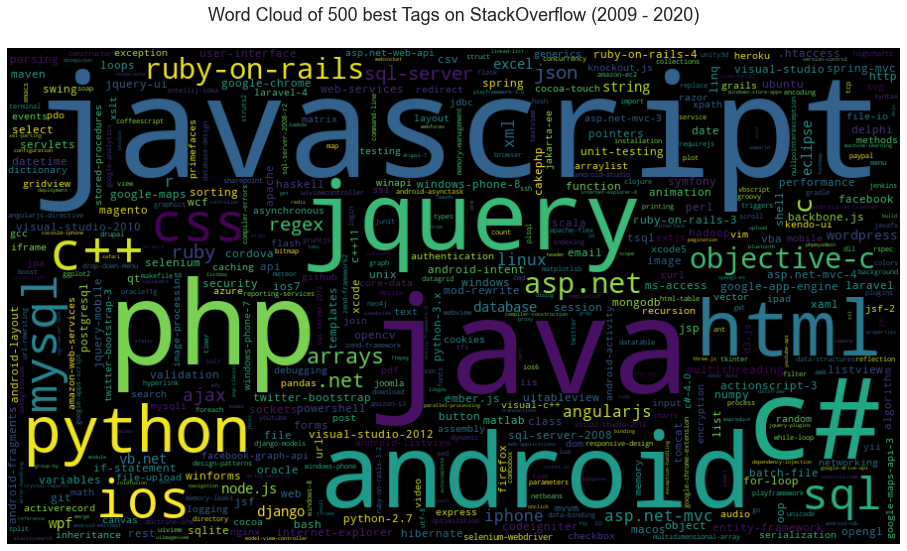

In [16]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(Tags_list.set_index('Nom').to_dict()['Nombre'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

### Filtrage des questions et tags

In [17]:
shape_avant = Tags_list.shape[0]
# Tags_list = Tags_list[Tags_list['Nombre'] >= 1000]
Tags_list = Tags_list[:100]
Tags_name_list = Tags_list['Nom'].to_list()
print('le nombre de Tags unique est passé de {} à {} soit on à perdue {:.2f}%'.format(shape_avant, Tags_list.shape[0], (1-Tags_list.shape[0]/shape_avant)*100))

le nombre de Tags unique est passé de 29021 à 100 soit on à perdue 99.66%


In [18]:
shape_avant = postXML1.shape[0]
postXML1 = postXML1[postXML1['AnswerCount'] >= 1]
postXML1 = postXML1[postXML1['ViewCount'] >= 100]
postXML1['Tags_list'] = postXML1['Tags_list'].apply(clean_tags).str.join(' ')
postXML1 = postXML1[postXML1['Tags_list'] != '']
print('le nombre de question est passé de {} à {} soit on à perdue {:.2f}%'.format(shape_avant, postXML1.shape[0], (1-postXML1.shape[0]/shape_avant)*100))

le nombre de question est passé de 1000000 à 665888 soit on à perdue 33.41%


### Nettoyage des questions

In [19]:
postXML1['Body_clean'] = postXML1['Body'].apply(clean_html_body)
stops = set(stopwords.words("english"))
postXML1['Text'] = (postXML1['Body_clean'] + " " + postXML1['Title']).apply(post_to_words)
postXML1['Text_len'] = postXML1['Text'].str.split().str.len()
borne_text = (postXML1['Text_len'].quantile(0.75) - postXML1['Text_len'].quantile(0.25))*2 + postXML1['Text_len'].quantile(0.75)

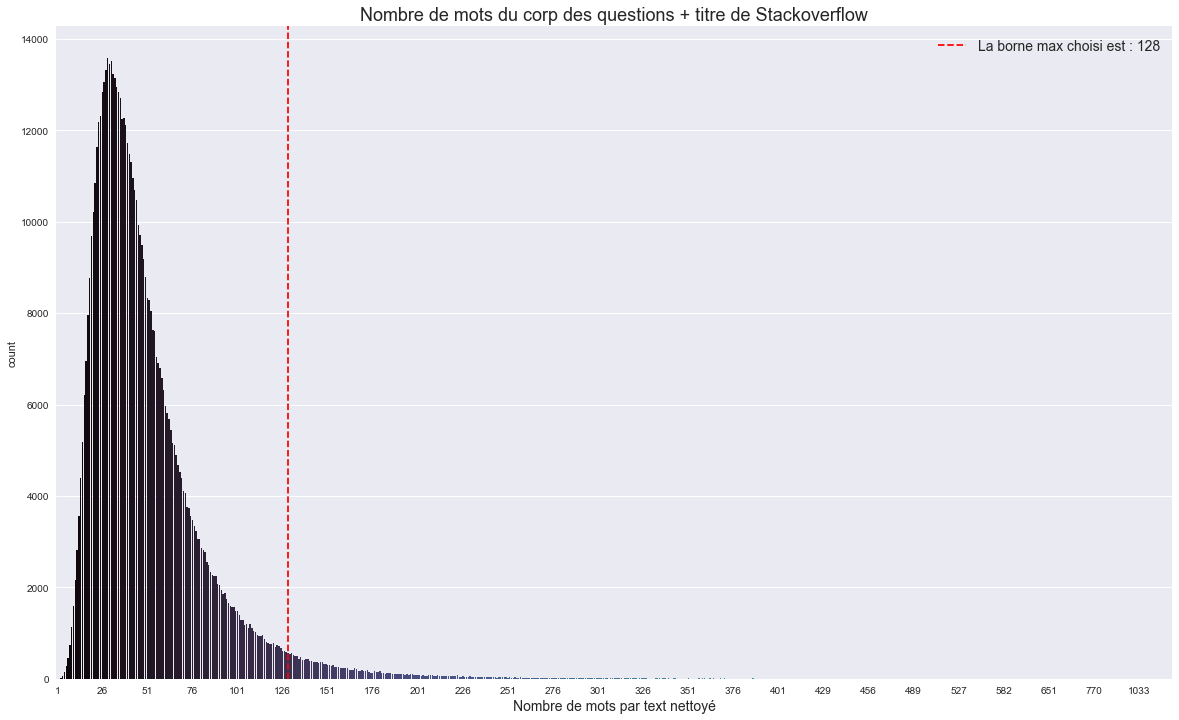

In [20]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML1['Text_len'], palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
plt.axvline(borne_text,
            color="r", linestyle='--',
            label="La borne max choisi est : {:.0f}".format(borne_text))
ax.set_xlabel("Nombre de mots par text nettoyé", fontsize=14)
plt.title("Nombre de mots du corp des questions + titre de Stackoverflow", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [21]:
postXML1 = postXML1[postXML1['Text_len'] < borne_text]
print('le nombre de question est passé de {} à {} soit on à perdue {:.2f}%'.format(shape_avant, postXML1.shape[0], (1-postXML1.shape[0]/shape_avant)*100))

le nombre de question est passé de 1000000 à 643026 soit on à perdue 35.70%


In [22]:
count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
bag_of_word = count_vect.fit_transform(postXML1['Text'])
word_sum = pd.DataFrame(bag_of_word.sum(axis=0).T, index=count_vect.get_feature_names_out(), columns=['freq']).sort_values(by='freq', ascending=False)['freq']
word_sum_log = np.log10(word_sum)
borne = (word_sum_log.quantile(0.75) - word_sum_log.quantile(0.25))*2 + word_sum_log.quantile(0.75)
vocabulary = word_sum_log[word_sum_log < borne].index.to_numpy()

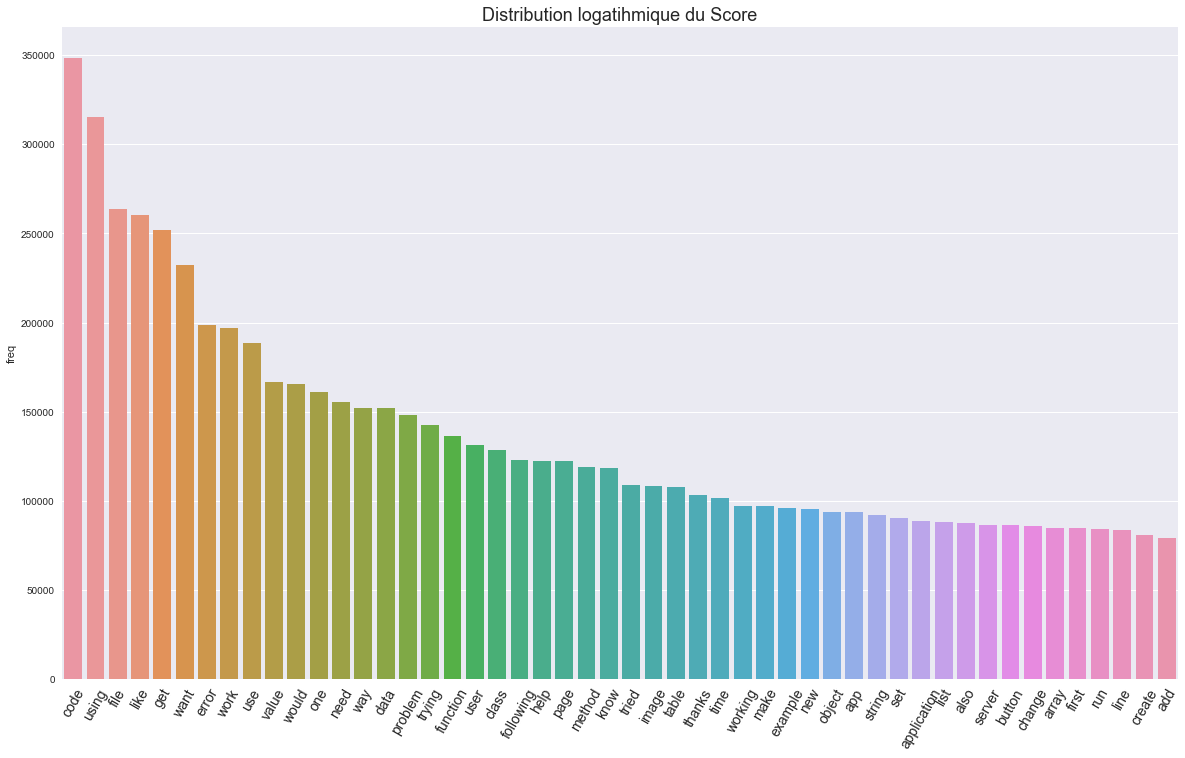

In [23]:
plt.figure(figsize=(20, 12))
plt.title("Distribution logatihmique du Score", fontsize=18)
sns.barplot(x=word_sum.index[:50], y=word_sum[:50])
plt.xticks(fontsize=14, rotation=60)
plt.show()

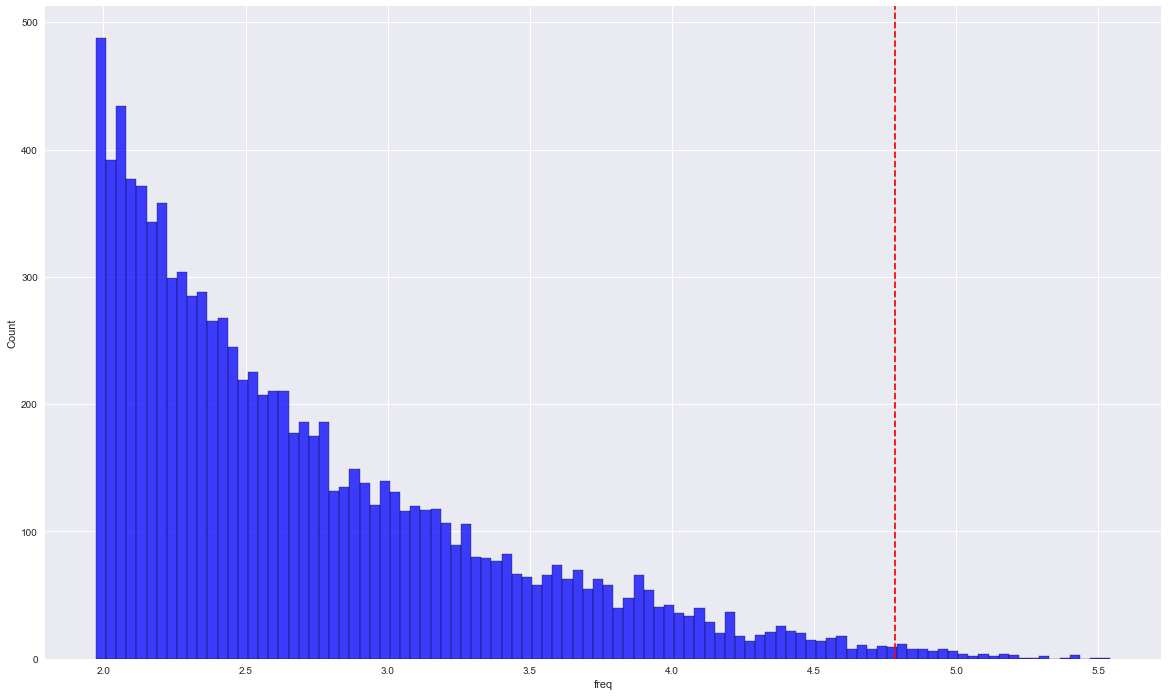

In [24]:
plt.figure(figsize=(20, 12))
sns.histplot(word_sum_log, color="blue", bins=100)
plt.axvline(borne,
            color="r", linestyle='--',
            label="La borne interquartile est : {:.2f}".format(borne))
plt.show()

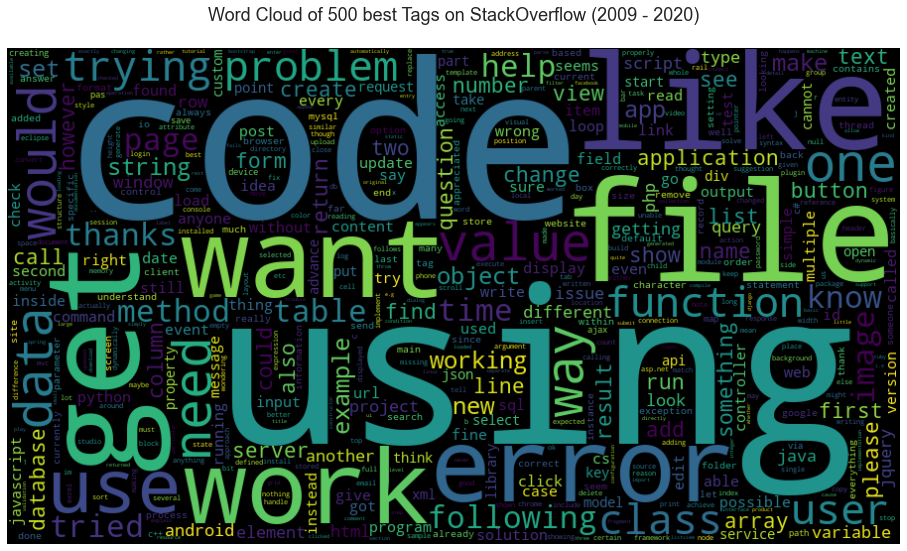

In [25]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log.to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

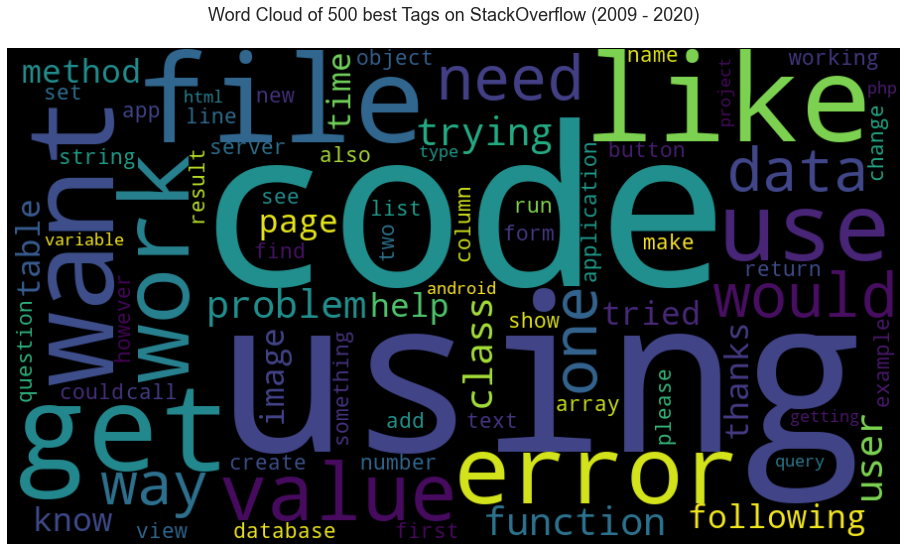

In [26]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log[word_sum_log > borne].to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

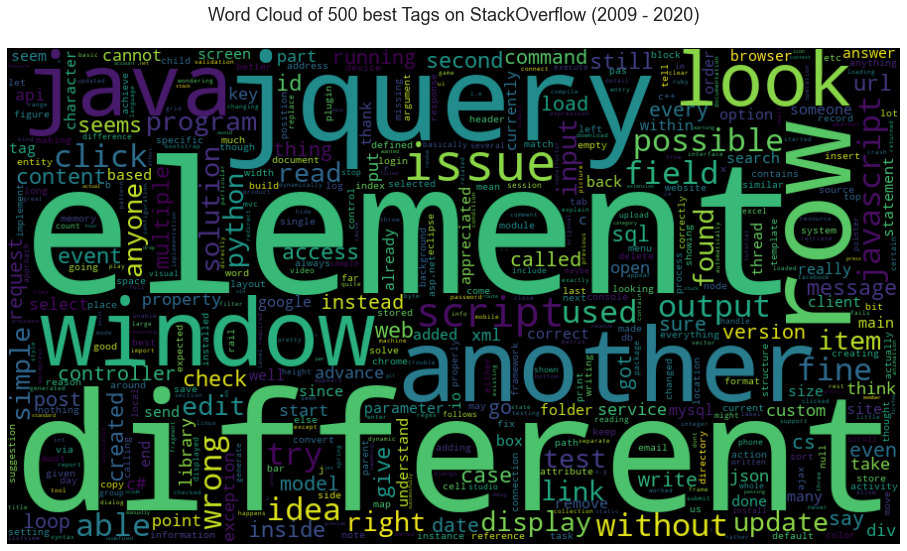

In [27]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log[word_sum_log < borne].to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

In [28]:
postXML1[["Text", "Tags_list"]].to_csv("Data/Posts_Clean_1.csv")
np.save("Data/Vocabulary.npy", vocabulary)

## De Cotée

In [ ]:
forest = RandomForestClassifier(n_jobs=-1)
clfc = ClassifierChain(forest)
clfc.fit(x_train_tfidf, y_train_tfidf)

ClassifierChain(base_estimator=RandomForestClassifier(n_jobs=-1))

In [ ]:
forest = RandomForestClassifier()
clf = MultiOutputClassifier(forest, n_jobs=-1)
clf.fit(x_train_tfidf, y_train_tfidf)
Y_Pred = clf.predict(x_test_tfidf)

In [ ]:
forest = RandomForestClassifier()
clf = OneVsRestClassifier(forest, n_jobs=-1)
clf.fit(x_train_tfidf, y_train_tfidf)
Y_Pred = clf.predict(x_test_tfidf)

In [ ]:
forest = RandomForestClassifier()
clf = OneVsRestClassifier(forest, n_jobs=-1)
y_score = clf.fit(x_train_tfidf, y_train_tfidf).decision_function(x_test_tfidf)

AttributeError: This 'OneVsRestClassifier' has no attribute 'decision_function'

## Préparation

In [17]:
post = pd.read_csv('Data/Posts_Clean_1.csv', index_col=0)
tagsXML = pd.read_csv('Data/TagsXML.csv', index_col=0)

In [18]:
tagsXML['Count_log'] = np.log10(tagsXML['Count'] + 1)
best_tags = tagsXML[tagsXML['Count_log'] > 4]
best_tags.dropna(inplace=True)

C:\Users\Jayma\AppData\Local\Temp\ipykernel_17480\4169173141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_tags.dropna(inplace=True)


In [19]:
post = post.sample(n=10000)

## Supervisé

In [20]:
tags_binarizer = MultiLabelBinarizer()
Y = tags_binarizer.fit_transform(post.Tags_List.str.split())
tags_mask = np.isin(tags_binarizer.classes_, best_tags['TagName'].to_numpy())
Y = Y[:,tags_mask]

count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
X_counts = count_vect.fit_transform(post.Text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [6]:
del post

In [21]:
tSVD = TruncatedSVD(n_components=100)
X_Tsvd = tSVD.fit_transform(X_tfidf)

In [22]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
  X_Tsvd, Y, test_size=0.2, random_state=9000)

In [23]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(x_train_tfidf, y_train_tfidf)

RandomForestClassifier(n_jobs=-1)

In [24]:
Y_Prob = forest.predict_proba(x_test_tfidf)
Y_Proba = []
for i in Y_Prob:
    Y_Proba.append(i[:,0])
Y_Proba = 1 - np.array(Y_Proba).T

In [25]:
n_classes = Y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_tfidf[:, i], Y_Proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_tfidf.ravel(), Y_Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

In [26]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

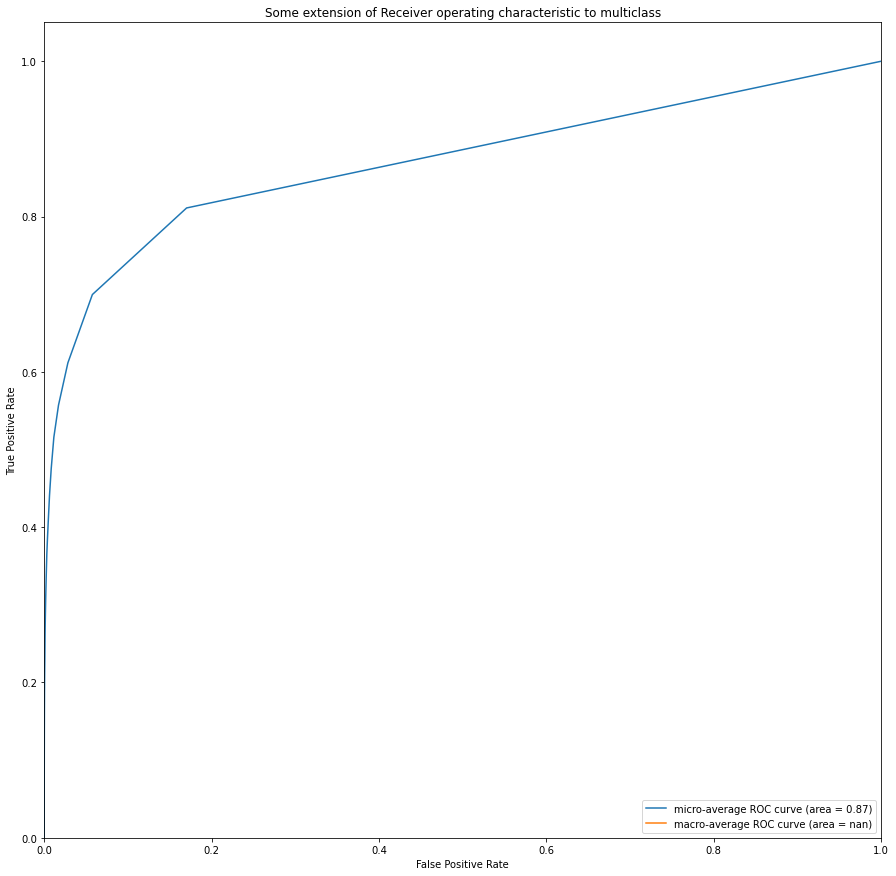

In [27]:
# Plot all ROC curves

plt.figure(figsize=[15,15])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [ ]:
Y_Pred = forest.predict(x_test_tfidf)

In [51]:
i = 0.5
while (tp + fp) < (tp + fn):
    Y_Est = Y_Proba > i
    mcm = multilabel_confusion_matrix(y_test_tfidf, Y_Est)
    tn = mcm[:, 0, 0].mean()
    tp = mcm[:, 1, 1].mean()
    fn = mcm[:, 1, 0].mean()
    fp = mcm[:, 0, 1].mean()
    i -= 0.01
    print(i)

0.49
0.48
0.47
0.45999999999999996
0.44999999999999996
0.43999999999999995
0.42999999999999994
0.41999999999999993
0.4099999999999999
0.3999999999999999
0.3899999999999999
0.3799999999999999
0.3699999999999999
0.3599999999999999
0.34999999999999987
0.33999999999999986
0.32999999999999985
0.31999999999999984
0.30999999999999983
0.2999999999999998
0.2899999999999998
0.2799999999999998
0.2699999999999998
0.2599999999999998
0.24999999999999978
0.23999999999999977
0.22999999999999976
0.21999999999999975
0.20999999999999974
0.19999999999999973
0.18999999999999972
0.17999999999999972
0.1699999999999997
0.1599999999999997
0.1499999999999997
0.13999999999999968
0.12999999999999967
0.11999999999999968
0.10999999999999968
0.09999999999999969


In [50]:
i = 0.5
Y_Est = Y_Proba > i
mcm = multilabel_confusion_matrix(y_test_tfidf, Y_Est)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()

In [52]:
[[tn,fn], [fp, tp]]

[[1987.8426395939086, 4.673434856175973],
 [5.055837563451776, 2.428087986463621]]

In [53]:
tp / (tp + fp)

0.32444042505087045

In [54]:
tp / (tp + fn)

0.34191088873004527

In [130]:
tot = tn + fn + fp + tp

In [48]:
tp + fp

7.483925549915398

In [49]:
tp + fn

7.101522842639595

## Test 1

In [55]:
bag_of_word = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
bag_of_word.fit(post['Text'].values.tolist())
X_bag = bag_of_word.transform(post['Text'].values.tolist())
text_tf_idn = TfidfTransformer()
text_tf_idn.fit(X_bag)
X_tf = text_tf_idn.transform(X_bag)

In [59]:
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0,
        n_jobs=-1)
# Fitter sur les données
lda.fit(X_bag)


# Run NMF
# nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
# nmf.fit(X_tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, n_jobs=-1,
                          random_state=0)

In [61]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(X_bag))


# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X_bag))

Log Likelihood:  -5002914.186493896
Perplexity:  1553.1855239951758


In [62]:
pyLDAvis.sklearn.prepare(lda, X_bag, bag_of_word)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.249682 -0.120471       1        1  34.089465
4     -0.233492  0.006397       2        1  12.904516
5     -0.171775 -0.183601       3        1   9.750224
6     -0.163292  0.172789       4        1   7.356284
15    -0.202665 -0.169101       5        1   6.752317
7     -0.117563  0.084082       6        1   5.363380
10    -0.083166  0.074179       7        1   4.391394
3     -0.168756  0.126770       8        1   4.363973
2      0.035441  0.135827       9        1   1.875395
0      0.003782 -0.010859      10        1   1.850781
12     0.111750  0.016347      11        1   1.719720
17     0.071340  0.066123      12        1   1.621072
16     0.061913  0.157686      13        1   1.438136
9      0.119158  0.065067      14        1   1.426180
19     0.066700 -0.195373      15        1   1.378385
11     0.171959  0.020116      16        1   1.035370
1      0.167899  0.025485      17        1   0.888847
18     0.185866 -0.116728      18        1   0.674435
13     0.193580 -0.070955      19        1   0.627345
14     0.201006 -0.083779      20        1   0.492782, topic_info=          Term         Freq        Total Category  logprob  loglift
3900      file  5001.000000  5001.000000  Default  30.0000  30.0000
6140      name  2972.000000  2972.000000  Default  29.0000  29.0000
8497    string  3323.000000  3323.000000  Default  28.0000  28.0000
4602      http  2051.000000  2051.000000  Default  27.0000  27.0000
2311     class  4445.000000  4445.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
8246  sockitem    18.245471    20.137685  Topic20  -5.2143   5.2142
8004  server.c    18.201255    20.138033  Topic20  -5.2167   5.2117
2482   company    85.727854   203.444257  Topic20  -3.6671   4.4486
6335  nullable    27.708322    38.314051  Topic20  -4.7965   4.9888
3314  doctrine    20.007205    27.658184  Topic20  -5.1221   4.9890

[1173 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.016366     #
0         4  0.272083     #
0         6  0.063418     #
0         8  0.045006     #
0        10  0.085921     #
...     ...       ...   ...
9965     12  0.591857   yes
9976     11  0.957665  yyyy
9978      2  0.008632     z
9978      6  0.975375     z
9986     19  0.991448   zip

[2794 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 6, 7, 16, 8, 11, 4, 3, 1, 13, 18, 17, 10, 20, 12, 2, 19, 14, 15])

In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(questions['Text'].values.tolist())
print(dtm_tf.shape)

In [302]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(questions['Text'].values.tolist())
print(dtm_tfidf.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1805: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


(9106, 3458)


In [303]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=20, random_state=0)

In [306]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.121121 -0.052967       1        1  8.477048
15     0.010787 -0.090182       2        1  8.143703
0      0.052540  0.085915       3        1  7.713408
10     0.070819  0.072736       4        1  6.346808
16     0.140892 -0.111445       5        1  6.034989
12     0.109483 -0.172987       6        1  6.014311
1      0.044329  0.071259       7        1  5.301357
9      0.162167 -0.070371       8        1  5.209381
14     0.159262  0.006753       9        1  5.153294
6     -0.122200  0.026916      10        1  4.820757
13    -0.168595 -0.048842      11        1  4.797513
5     -0.175148 -0.037694      12        1  4.600593
8     -0.010247  0.215618      13        1  4.283463
19    -0.062834 -0.111473      14        1  4.127095
4      0.084749 -0.088768      15        1  4.114257
18    -0.231056 -0.031488      16        1  3.720319
11    -0.068133  0.006652      17        1  3.648246
17     0.027082  0.025820      18        1  2.916007
2      0.096273  0.105749      19        1  2.611250
3      0.000951  0.198799      20        1  1.966199, topic_info=             Term         Freq        Total Category  logprob  loglift
1621         java  1707.000000  1707.000000  Default  30.0000  30.0000
2749       server  2905.000000  2905.000000  Default  29.0000  29.0000
1149         file  4231.000000  4231.000000  Default  28.0000  28.0000
435         class  2365.000000  2365.000000  Default  27.0000  27.0000
707      database  1895.000000  1895.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
135   application    88.797632  2817.116313  Topic20  -4.5524   0.4720
1728         line    73.793751  1170.380223  Topic20  -4.7375   1.1653
2650          run    56.830283  1251.295736  Topic20  -4.9987   0.8372
3274        using    62.742256  4232.138838  Topic20  -4.8997  -0.2824
3349          way    61.214254  3956.118501  Topic20  -4.9244  -0.2396

[1280 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3         1  0.118118     abort
3         9  0.826829     abort
6         1  0.939796  abstract
6        17  0.009998  abstract
6        18  0.039991  abstract
...     ...       ...       ...
3452     16  0.861531      yyyy
3453     10  0.980900      zend
3456     15  0.777824      zone
3456     16  0.102345      zone
3456     18  0.102345      zone

[5344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 16, 1, 11, 17, 13, 2, 10, 15, 7, 14, 6, 9, 20, 5, 19, 12, 18, 3, 4])

In [20]:
questions['Tags'][8]

['unix', 'algorithm', 'performance']

In [284]:
no_top_words = 10
display_topics(lda, bag_of_word.get_feature_names(), no_top_words)

Topic 0:
ruby error lib usr 5.8 ’ hash ‘ gem file
Topic 1:
email path send message address socket font sending outlook mail
Topic 2:
test class testing unit session end rail interface def method
Topic 3:
object class function type code new like get way method
Topic 4:
linux cs core width div style height cpu space div>
Topic 5:
database sql table data server query column select stored row
Topic 6:
string array + b character byte c char branch convert
Topic 7:
dialog src jrst-0.8.1 11-30-07 http js.js>< script><script messagebox window www.uhwc.ru
Topic 8:
1 0 3 2 n int 0-9 4 regex number
Topic 9:
tomcat servlet unknown www.example.com applicationfilterchain.java 25 source 2d sep 46
Topic 10:
resolution mongrel_r 11628 retcode questionnaire 0,8 potion perldoc @raw_num long
Topic 11:
customizabletable sp b0 car 28-aug-2008 crystal sp_cursorfetch vehicle depression 180150003,32,1,1
Topic 12:
exception error thread debug catch assembly throw video try contact
Topic 13:
text name button val

In [292]:
no_top_words = 10
display_topics(nmf, bag_of_word.get_feature_names(), no_top_words)

Topic 0:
like would code use way using one know get need
Topic 1:
table database data column row query mysql select sql field
Topic 2:
class public method static private void name interface property return
Topic 3:
file xml directory path folder open line copy log script
Topic 4:
page javascript html browser cs content link web button tag
Topic 5:
visual studio 2008 2005 v c++ build solution ide express
Topic 6:
.net framework 2.0 3.5 c# application assembly sp1 version library
Topic 7:
server sql 2005 database procedure stored query linq 2000 connection
Topic 8:
php mysql script apache echo variable zend site way session
Topic 9:
test unit testing run framework nunit integration write mock code
Topic 10:
string value array return function convert int 1 0 name
Topic 11:
control form property event source button textbox custom version wpf
Topic 12:
window application xp form linux o vista mac machine process
Topic 13:
object type property collection method new return reference create se

## Visualisation

In [244]:
bag_of_word = CountVectorizer(lowercase=False, token_pattern="\S+")
bag_of_word.fit(questions['Text'].values.tolist())
X_bag = bag_of_word.transform(questions['Text'].values.tolist())
text_tf_idn = TfidfTransformer()
text_tf_idn.fit(X_bag)
X_tf = text_tf_idn.transform(X_bag)

In [256]:
tSVD = TruncatedSVD(n_components=3)
X_acp = tSVD.fit_transform(X_tf)

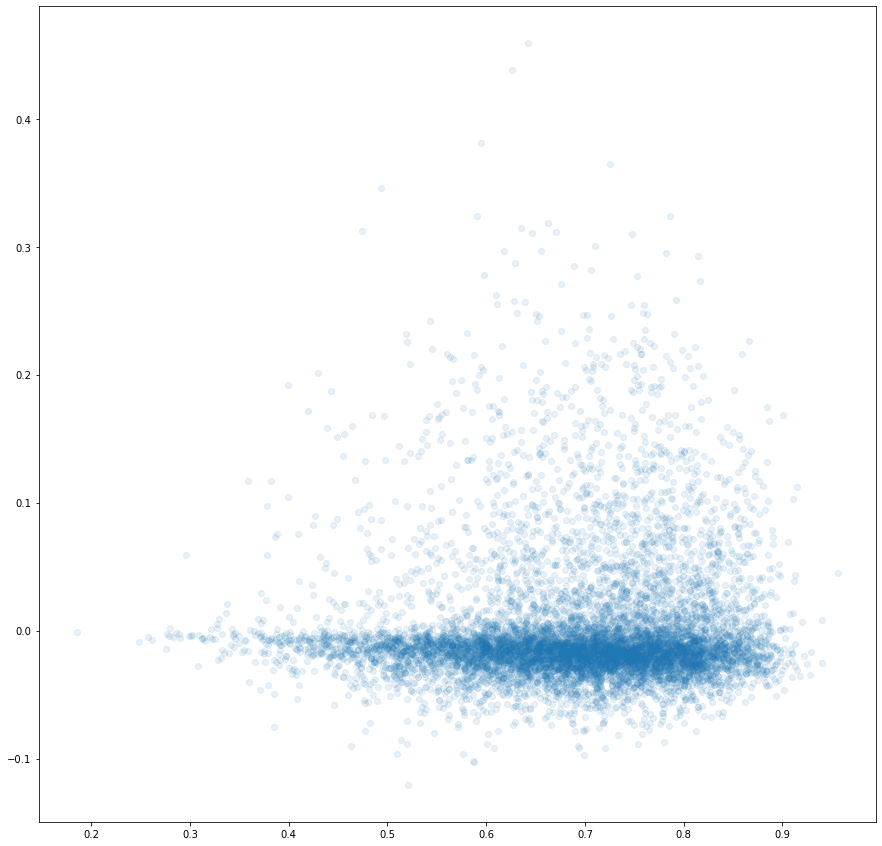

In [257]:
plt.figure(figsize=(15,15))
plt.scatter(X_acp[:,0], X_acp[:,1],alpha=0.1)

In [97]:
tags_tf_idn = TfidfVectorizer(lowercase=False)
tags_tf_idn.fit(questions['Tags_list'])
y_tf = tags_tf_idn.transform(questions['Tags_list'])

In [98]:
tSVD = TruncatedSVD(n_components=3)
y_acp = tSVD.fit_transform(y_tf)

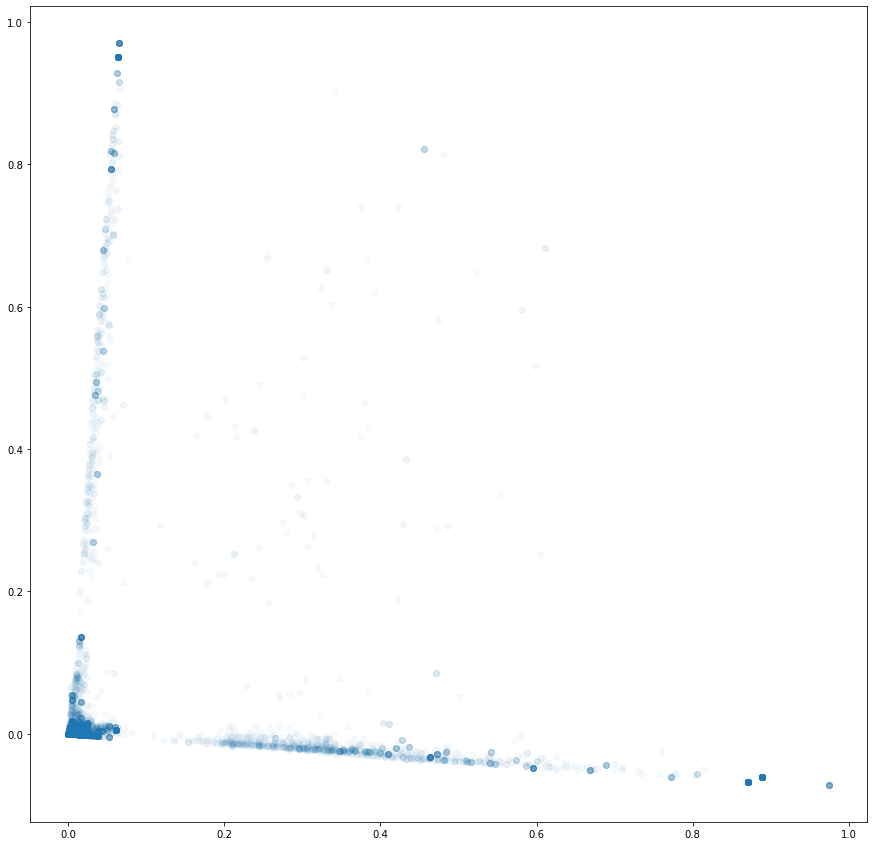

In [99]:
plt.figure(figsize=(15,15))
plt.scatter(y_acp[:,0], y_acp[:,1],alpha=0.03)